In [1]:
import qiskit
from qiskit import QuantumCircuit
import numpy as np
import copy
import time
from scipy.optimize import minimize
from typing import Optional, List, Dict, Tuple, Union
from qiskit.result import marginal_counts

from qiskit import pulse
from qiskit.providers.aer.pulse import duffing_system_model
from scipy.sparse import csr_matrix


import logging
logger = logging.getLogger()

# imports for qiskit dynamics simulation
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver
from qiskit.quantum_info.states import Statevector

# optimizers
from qiskit.algorithms.optimizers import SPSA
# other possible optimizer
# from scipy.optimize import fmin_l_bfgs_b
# from qiskit.algorithms.optimizers import QNSPSA

Imports needed from qiskit_nature

In [2]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper, BravyiKitaevMapper
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer, ActiveSpaceTransformer
# Solvers
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_nature.algorithms import GroundStateEigensolver

# for HF calculation
from pyscf import scf
from pyscf import gto


Numpy 1.16 has memory leak bug  https://github.com/numpy/numpy/issues/13808
It is recommended to downgrade to numpy 1.15 or older


# Define the system Hamiltonian
We define the parameters of a duffling oscillator - which represent a superconducting based quantum computers.

The parameters used are relevant for a fixed frequency computers, like those used by IBM. 3 energy levels are taken into account in the simulation to simulate also leakage

In [3]:
from qiskit.providers.fake_provider import FakeLagos
backend_lagos = FakeLagos()
lagos_backend_config = backend_lagos.configuration()
lagos_ham_params = lagos_backend_config.hamiltonian['vars']

In [4]:
backend_lagos.configuration().to_dict()['channels']

{'acquire0': {'operates': {'qubits': [0]},
  'purpose': 'acquire',
  'type': 'acquire'},
 'acquire1': {'operates': {'qubits': [1]},
  'purpose': 'acquire',
  'type': 'acquire'},
 'acquire2': {'operates': {'qubits': [2]},
  'purpose': 'acquire',
  'type': 'acquire'},
 'acquire3': {'operates': {'qubits': [3]},
  'purpose': 'acquire',
  'type': 'acquire'},
 'acquire4': {'operates': {'qubits': [4]},
  'purpose': 'acquire',
  'type': 'acquire'},
 'acquire5': {'operates': {'qubits': [5]},
  'purpose': 'acquire',
  'type': 'acquire'},
 'acquire6': {'operates': {'qubits': [6]},
  'purpose': 'acquire',
  'type': 'acquire'},
 'd0': {'operates': {'qubits': [0]}, 'purpose': 'drive', 'type': 'drive'},
 'd1': {'operates': {'qubits': [1]}, 'purpose': 'drive', 'type': 'drive'},
 'd2': {'operates': {'qubits': [2]}, 'purpose': 'drive', 'type': 'drive'},
 'd3': {'operates': {'qubits': [3]}, 'purpose': 'drive', 'type': 'drive'},
 'd4': {'operates': {'qubits': [4]}, 'purpose': 'drive', 'type': 'drive'},
 '

In [5]:
# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
lagos_oscillator_freqs_4q = [lagos_ham_params['wq0'] / (np.pi *2e9), 
                             lagos_ham_params['wq1'] / (np.pi *2e9),
                             lagos_ham_params['wq2'] / (np.pi *2e9),
                             lagos_ham_params['wq3'] / (np.pi *2e9)] # numbers are in Ghz
lagos_anharm_freqs_4q = [lagos_ham_params['delta0'] / (np.pi *2e9),
                         lagos_ham_params['delta1'] / (np.pi *2e9),
                         lagos_ham_params['delta2'] / (np.pi *2e9),
                         lagos_ham_params['delta3'] / (np.pi *2e9)] # numbers are in Ghz

# drive strengths
lagos_drive_strengths_4q = [lagos_ham_params['omegad0'] / (np.pi *2e9),
                            lagos_ham_params['omegad1'] / (np.pi *2e9),
                            lagos_ham_params['omegad2'] / (np.pi *2e9),
                            lagos_ham_params['omegad3'] / (np.pi *2e9)] # numbers are in Ghz

# specify coupling as a dictionary
lagos_coupling_dict_4q = {(0,1): lagos_ham_params['jq0q1'] / (np.pi *2e9),
                         (1,2): lagos_ham_params['jq1q2'] / (np.pi *2e9),
                         (2,3): lagos_ham_params['jq1q3'] / (np.pi *2e9)} # numbers are in Ghz

# sample duration for pulse instructions
dt = 0.222 # numbers are in nano-seconds

# create the model
lagos_model_3levels = duffing_system_model(dim_oscillators=3,
                                       oscillator_freqs=lagos_oscillator_freqs_4q,
                                       anharm_freqs=lagos_anharm_freqs_4q,
                                       drive_strengths=lagos_drive_strengths_4q,
                                       coupling_dict=lagos_coupling_dict_4q,
                                       dt=dt)

# Define functions to run the simulation

### translate pulses to driving signals and run a simulation

In [6]:
def destroy(N, offset=0):
    """Destruction (lowering) operator.
    Args:
        N (int): Dimension of Hilbert space.
        offset (int): (default 0) The lowest number state that is included
                      in the finite number state representation of the operator.
    Returns:
        Qobj: Qobj for lowering operator.
    Raises:
        ValueError: Invalid input.
    """
    if not isinstance(N, (int, np.integer)):  # raise error if N not integer
        raise ValueError("Hilbert space dimension must be integer value")
    data = np.sqrt(np.arange(offset + 1, N + offset, dtype=complex))
    ind = np.arange(1, N, dtype=np.int32)
    ptr = np.arange(N + 1, dtype=np.int32)
    ptr[-1] = N - 1
    return csr_matrix((data, ind, ptr), shape=(N, N)).toarray()

def create(N, offset=0):
    temp = destroy(N, offset)
    return temp.transpose().conj()

In [7]:
lagos_model_3levels.hamiltonian._variables

OrderedDict([('v0', 5.235301508394164),
             ('alpha0', -0.33986713855915607),
             ('r0', 0.15572915002749838),
             ('v1', 5.099410549133616),
             ('alpha1', -0.34324840429383563),
             ('r1', 0.15218167864422943),
             ('v2', 5.1878309330056975),
             ('alpha2', -0.3419316690031256),
             ('r2', 0.15536527727345825),
             ('v3', 4.9868387914029295),
             ('alpha3', -0.3452928861203798),
             ('r3', 0.13745759245761868),
             ('j01', 0.0017239661070310695),
             ('j12', 0.003306427365570105),
             ('j23', 0.0032190776031028067)])

In [8]:
def run_ansatz(system_model, pulses, dt=0.222, initial_state=None, decoherence=False):
    hamiltonian_model = system_model.hamiltonian

    static_ham = \
    np.pi * (2 * hamiltonian_model._variables['v0'] - hamiltonian_model._variables['alpha0'])\
        * hamiltonian_model._system[0][0] + \
    np.pi * (2 * hamiltonian_model._variables['v1'] - hamiltonian_model._variables['alpha1'])\
        * hamiltonian_model._system[1][0] + \
    np.pi * (2 * hamiltonian_model._variables['v2'] - hamiltonian_model._variables['alpha2'])\
        * hamiltonian_model._system[2][0] + \
    np.pi * (2 * hamiltonian_model._variables['v3'] - hamiltonian_model._variables['alpha3'])\
        * hamiltonian_model._system[3][0] + \
    np.pi * hamiltonian_model._variables['alpha0'] * hamiltonian_model._system[4][0] +\
    np.pi * hamiltonian_model._variables['alpha1'] * hamiltonian_model._system[5][0] +\
    np.pi * hamiltonian_model._variables['alpha2'] * hamiltonian_model._system[6][0] +\
    np.pi * hamiltonian_model._variables['alpha3'] * hamiltonian_model._system[7][0] +\
    2 * np.pi * hamiltonian_model._variables['j01'] * hamiltonian_model._system[8][0] +\
    2 * np.pi * hamiltonian_model._variables['j12'] * hamiltonian_model._system[9][0] +\
    2 * np.pi * hamiltonian_model._variables['j23'] * hamiltonian_model._system[10][0]
  
    carrier_freqs = []
    ham_operators = []
    for channel in pulses.channels:
        if channel.name == 'd0':
            carrier_freqs.append(hamiltonian_model._variables['v0'])
            ham_operators.append(2 * np.pi * hamiltonian_model._variables['r0'] * \
                                   hamiltonian_model._system[11][0].data) #D0
        elif channel.name == 'd1':
            carrier_freqs.append(hamiltonian_model._variables['v1'])
            ham_operators.append(2 * np.pi * hamiltonian_model._variables['r1'] * \
                                   hamiltonian_model._system[12][0].data) #D1
        elif channel.name == 'd3': # in lagos simulation, qubit 2 is physical qubit 3
            carrier_freqs.append(hamiltonian_model._variables['v2'])
            ham_operators.append(2 * np.pi * hamiltonian_model._variables['r2'] * \
                                   hamiltonian_model._system[13][0].data) #D2
        elif channel.name == 'd5': # in lagos simulation, qubit 3 is physical qubit 5
            carrier_freqs.append(hamiltonian_model._variables['v3'])
            ham_operators.append(2 * np.pi * hamiltonian_model._variables['r3'] * \
                                   hamiltonian_model._system[14][0].data) #D3
        elif channel.name == 'u0': #U0 - Drive0, target 1
            carrier_freqs.append(hamiltonian_model._variables['v1'])
            
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            XZ = np.kron((destroy(3) + create(3)), 0.5 * np.eye(3) - (create(3) @ destroy(3)))
            IZ = np.kron(np.eye(3), 0.5 * np.eye(3) - (create(3) @ destroy(3)))
            XI = np.kron((create(3) + destroy(3)), np.eye(3))
            
            temp_op = hamiltonian_model._variables['r0'] * \
                                (a1 * IZ +
                                 a2 * XI + \
                                 a3 * XZ)
            ham_operators.append(np.kron(np.eye(3), np.kron(np.eye(3), temp_op)))
            
        elif channel.name == 'u1': #U1 - Drive1, target 0)
            carrier_freqs.append(hamiltonian_model._variables['v0'])
            
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            ZX = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), (destroy(3) + create(3)))
            ZI = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.eye(3))
            IX = np.kron(np.eye(3), (create(3) + destroy(3)))
            
            temp_op = hamiltonian_model._variables['r0'] * \
                                (a1 * ZI +
                                 a2 * IX + \
                                 a3 * ZX)
            ham_operators.append(np.kron(np.eye(3), np.kron(np.eye(3), temp_op)))
            
        elif channel.name == 'u2': #U2 - Drive1, target 2)
            carrier_freqs.append(hamiltonian_model._variables['v2'])
            
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            ZX = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), (destroy(3) + create(3)))
            ZI = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.eye(3))
            IX = np.kron(np.eye(3), (create(3) + destroy(3)))
            
            temp_op = hamiltonian_model._variables['r1'] * \
                                (a1 * ZI +
                                 a2 * IX + \
                                 a3 * ZX)
            ham_operators.append(np.kron(np.kron(np.eye(3), temp_op), np.eye(3)))
            
        elif channel.name == 'u3': #U3 - Drive2, target 1) in lagos - it will be (1, 3). simulation (1, 2)
            carrier_freqs.append(hamiltonian_model._variables['v2'])
            
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            ZX = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), (destroy(3) + create(3)))
            ZI = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.eye(3))
            IX = np.kron(np.eye(3), (create(3) + destroy(3)))
            
            temp_op = hamiltonian_model._variables['r1'] * \
                                (a1 * ZI +
                                 a2 * IX + \
                                 a3 * ZX)
            ham_operators.append(np.kron(np.kron(np.eye(3), temp_op), np.eye(3)))
            
        elif channel.name == 'u4': #U4 - Drive1, target 3)
            carrier_freqs.append(hamiltonian_model._variables['v3'])
            
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            ZIX = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.kron(np.eye(3), (destroy(3) + create(3))))
            ZII = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.kron(np.eye(3), np.eye(3)))
            IIX = np.kron(np.eye(3), np.kron(np.eye(3), (create(3) + destroy(3))))
            
            temp_op = hamiltonian_model._variables['r1'] * \
                                (a1 * ZII +
                                 a2 * IIX + \
                                 a3 * ZIX)
            ham_operators.append(np.kron(np.eye(3), temp_op))
            
        elif channel.name == 'u5': #U5 - Drive3, target 1)
            carrier_freqs.append(hamiltonian_model._variables['v1'])
            
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            ZIX = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.kron(np.eye(3), (destroy(3) + create(3))))
            ZII = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.kron(np.eye(3), np.eye(3)))
            IIX = np.kron(np.eye(3), np.kron(np.eye(3), (create(3) + destroy(3))))
            
            temp_op = hamiltonian_model._variables['r3'] * \
                                (a1 * ZII +
                                 a2 * IIX + \
                                 a3 * ZIX)
            ham_operators.append(np.kron(np.eye(3), temp_op))
            
        elif channel.name == 'u6': #U6 - Drive3, target 5) in lagos simulation it will be (2, 3)
            carrier_freqs.append(hamiltonian_model._variables['v3'])
            
            a1 = -6
            a2 = 0.04
            a3 = -0.2
            
            ZX = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), (destroy(3) + create(3)))
            ZI = np.kron(0.5 * np.eye(3) - (create(3) @ destroy(3)), np.eye(3))
            IX = np.kron(np.eye(3), (create(3) + destroy(3)))
            
            temp_op = hamiltonian_model._variables['r2'] * \
                                (a1 * ZI +
                                 a2 * IX + \
                                 a3 * ZX)
            ham_operators.append(np.kron(np.kron(temp_op, np.eye(3)), np.eye(3)))

    signal_converter = InstructionToSignals(dt, carriers=carrier_freqs)
    
    try:
        ansatz_signals = signal_converter.get_signals(pulses)
    except:
        print("error in converting signal")
        print(carrier_freqs)
        print(pulses)
    
    dissipators_operators = []
    if decoherence:
        num_qubits = 4
        T1 = 100000
        T2 = 100000
        gamma_1 = 1 / T1
        gamma_2 = (1 / T2 + gamma_1 /2 ) /2
        X = create(3) + destroy(3) # extension to Operator.from_label('X')
        Y = 1j * (create(3) - destroy(3)) # extension to Operator.from_label('Y')
        Z = destroy(3) @ create(3) - create(3) @ destroy(3) # extension to Operator.from_label('Z')
        s_p = 0.5 * (X + 1j * Y)

        for qubit in range(num_qubits):
            zeros = Operator(np.zeros((3 ** num_qubits, 3 ** num_qubits)), 
                             input_dims=[3]*num_qubits, output_dims=[3]*num_qubits)
            dissipators_operators.append(zeros + Operator(np.sqrt(gamma_1) * s_p)(qubit))
            dissipators_operators.append(zeros + Operator(np.sqrt(gamma_2) * Z)(qubit))
            
        hamiltonian_solver = Solver(
            static_hamiltonian=static_ham,
            hamiltonian_operators=ham_operators,
            hamiltonian_signals=ansatz_signals,
            static_dissipators=dissipators_operators,
            rotating_frame=static_ham,
            rwa_cutoff_freq=2*hamiltonian_model._variables['v0']
        )
                        
    else:
        hamiltonian_solver = Solver(
            static_hamiltonian=static_ham,
            hamiltonian_operators=ham_operators,
            hamiltonian_signals=ansatz_signals,
            rotating_frame=static_ham,
            rwa_cutoff_freq=2*hamiltonian_model._variables['v0']
        )
    
    if initial_state is not None:
        init_state = initial_state
    else:
        groud_4q_3levels = Statevector([1] + [0] * ((3**4) - 1))
        init_state = groud_4q_3levels

    ansatz_res = hamiltonian_solver.solve(t_span=[0., pulses.duration*dt],
                                          y0=init_state, atol=1e-8, rtol=1e-8)
    return ansatz_res

### Calculate eigen-energy given measurement in the Molecule pauli bases

In [9]:
# define relevant functions
def expval_with_variance(counts,
                         operator_coeff: int,
                         diagonal: Optional[np.ndarray] = None,
                        finite_sampling=True) -> Tuple[float, float]:
    r"""Compute the expectation value of a diagonal operator from counts.

    Args:
        counts: counts object.
        diagonal: Optional, values of the diagonal observable. If None the
                  observable is set to :math:`Z^\otimes n`.

    Returns:
        (float, float): the expectation value and variance.
    """
    if finite_sampling:
        # Get counts shots and probabilities
        probs = np.array(list(counts.values()))
        shots = probs.sum()
        probs = probs / shots
        
        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in counts.keys()])
        else:
            keys = [int(key, 2) for key in counts.keys()]
            coeffs = np.asarray(diagonal[keys])
            
        # Compute expval
        expval = coeffs.dot(probs)
        
        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(probs)
        else:
            sq_expval = (coeffs ** 2).dot(probs)
        variance = (sq_expval - expval ** 2) / shots
    else:
        probs = counts

        # Get diagonal operator coefficients
        if diagonal is None:
            coeffs = np.array([(-1) ** (key.count('1') % 2)
                               for key in probs.keys()])
        else:
            keys = [int(key, 2) for key in probs.keys()]
            coeffs = np.asarray(diagonal[keys])

        # Compute expval
        expval = coeffs.dot(list(probs.values()))

        # Compute variance
        if diagonal is None:
            # The square of the parity diagonal is the all 1 vector
            sq_expval = np.sum(list(probs.values()))
        else:
            sq_expval = (coeffs ** 2).dot(list(probs.values()))
        variance = (sq_expval - expval ** 2)# / shots

    # Compute standard deviation
    if variance < 0:
        if not np.isclose(variance, 0):
            logger.warning(
                'Encountered a negative variance in expectation value calculation.'
                '(%f). Setting standard deviation of result to 0.', variance)
        variance = 0.0
    return expval * operator_coeff, variance * abs(operator_coeff) ** 2

def calculate_accumulate_exp_val(probs, coeffs, finite_sampling):
    combined_expval = 0.0
    combined_variance = 0.0
    if type(probs) != list:
        probs = [probs]
    for ind, result in enumerate(probs):
        exp_val, exp_var = expval_with_variance(result, coeffs[ind], finite_sampling=finite_sampling)
        # Accumulate
        combined_expval += exp_val
        combined_variance += exp_var
    combined_stddev = np.sqrt(combined_variance)
    return combined_expval, combined_stddev

### Measure the simulation result in all the given pauli bases

In [10]:
hadamard = (1 / np.sqrt(2)) * np.array([[1,1],[1,-1]])
s_dg = np.array([[1,0],[0,1j]])
identity = np.array([[1,0],[0,1]])

def finite_sampling_measure(state, paulis, coeffs, leakage=False, shots=10000):
    ansatz_density_matrix = qiskit.quantum_info.DensityMatrix(state)
    if leakage:
        # filter out leakage
        wanted_indexes = [0, 1, 3, 4, 9, 10, 12, 13, 27, 28, 30, 31, 36, 37, 39, 40]
        matrix = []
        for i in wanted_indexes:
            temp_row = []
            for j in wanted_indexes:
                temp_row.append(ansatz_density_matrix.data[i, j])
            matrix.append(temp_row)
        reduced_density_matrix = qiskit.quantum_info.DensityMatrix(matrix)
        leakage_prob = 1 - sum(reduced_density_matrix.probabilities())
        print("leakage percent: " + str(leakage_prob*100) + "%")
        ansatz_density_matrix = reduced_density_matrix / reduced_density_matrix.trace()

    # apply rotations to the result state
    results = [] 
    for pauli in paulis:
        measure_op = 1
        marginal_qubits = list(range(4))
        qubits_to_marginalize_out = []
        for i, val in enumerate(reversed(pauli)):
            if val == 'Y':
                cur_measure_op = hadamard @ s_dg
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'X':
                cur_measure_op = hadamard
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'Z':
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
            if val == 'I': # we calculate expectation value, so we do not need to measure the identity
                cur_measure_op = identity
                measure_op = np.kron(cur_measure_op, measure_op)
                qubits_to_marginalize_out.append(i)

        measured_density_matrix = ansatz_density_matrix.evolve(measure_op)

        if shots is not None:
            counts = measured_density_matrix.sample_counts(shots)
            if qubits_to_marginalize_out:
                for qubit in qubits_to_marginalize_out:
                    marginal_qubits.remove(qubit)
                counts = marginal_counts(counts, marginal_qubits)
            results.append(counts)
            finite_sampling = True
        else:
            probs = measured_density_matrix.probabilities_dict()
            if qubits_to_marginalize_out:
                for qubit in qubits_to_marginalize_out:
                    marginal_qubits.remove(qubit)
                probs = marginal_counts(probs, marginal_qubits)
            results.append(probs)
            finite_sampling=False
    
    expval, stddev = calculate_accumulate_exp_val(results, coeffs, finite_sampling)
    return expval, stddev

### the loss function - gets all the parameters and return the energy

In [11]:
def evaluate_energy(theta, paulis, coeffs, system_model, dt=0.222, decoherence=False, shots=None):
    init_sched = ansatz_gate_inspired_weighted_3layers(theta, dt)
        
    print(theta)
    ansatz_result = run_ansatz(system_model, init_sched, dt, decoherence=decoherence)
    #expval, stddev = perfect_measure(ansatz_result.y[-1], paulis, coeffs, leakage=True)
    expval, stddev = finite_sampling_measure(ansatz_result.y[-1], paulis[1:], coeffs[1:], leakage=True, shots=shots)
    print("energy: " + str(expval + coeffs[0]))
    # in case I will want to return also the varience and the counts
    # return results, expval, stddev
    
    # save in global variables the mid-optimization values
    thetas.append(copy.deepcopy(theta))
    values.append(expval)
    states.append(ansatz_result.y[-1])
    return expval.real

a function that already have the static parameters hard-coded for easier use

In [12]:
def calculate_energy(theta):
    paulis = all_paulis[-1]
    coeffs = all_coeffs[-1]
    system_model = lagos_model_3levels
    dt = 0.222
    shots = 10000
    decoherence = True
    energy = evaluate_energy(theta, paulis, coeffs, system_model, dt, decoherence, shots)
    return energy

# Define the ansatz

In [14]:
def create_pansatz_layer(two_qubit_durations, two_qubit_width, single_qubit_durations, 
                         x_amp, x_sigma, x_beta, control_amp, first_layer=False):
    single_qubit_drives = []
    two_qubit_drives = []
    two_qubit_tag_drives = []
    
    # two qubit pulses
    if not first_layer:
        for cur_dur, cur_width in zip(two_qubit_durations, two_qubit_width):
            if cur_dur != 0:
                two_qubit_drive = list(qiskit.pulse.library.gaussian_square(duration=abs(int(cur_dur/2)), 
                                                              amp=amp_fun(cur_dur/2, control_amp), sigma=64,
                                                              width=cur_width/2).samples)
                two_qubit_drive, _ = add_padding(two_qubit_drive)
                two_qubit_drives.append(two_qubit_drive)

                two_qubit_tag_drive = list(qiskit.pulse.library.gaussian_square(duration=abs(int(cur_dur/2)), 
                                                              amp=-1*amp_fun(cur_dur/2, control_amp), sigma=64,
                                                              width=cur_width/2).samples)
                two_qubit_tag_drive, _ = add_padding(two_qubit_tag_drive)
                two_qubit_tag_drives.append(two_qubit_tag_drive)
            else:
                two_qubit_drives.append([])
                two_qubit_tag_drives.append([])
    
    # single qubit pulses
    for cur_dur in single_qubit_durations:
        if cur_dur != 0:
            if abs(cur_dur) > 32:
                single_qubit_drive = list(qiskit.pulse.library.drag(abs(cur_dur), amp_fun(cur_dur, x_amp),
                                                 x_sigma, x_beta).samples)
                single_qubit_drive, _ = add_padding(single_qubit_drive)
                single_qubit_drives.append(single_qubit_drive)
            else:
                temp_width = abs(cur_dur) - 14
                if temp_width < 0:
                    temp_width = abs(cur_dur)
                single_qubit_drive = list(qiskit.pulse.library.gaussian_square(duration=abs(cur_dur), 
                                                                     amp=amp_fun(cur_dur, x_amp),
                                                                     sigma=x_sigma, 
                                                                     width=temp_width).samples)
                single_qubit_drive, _ = add_padding(single_qubit_drive)
                single_qubit_drives.append(single_qubit_drive)
        else:
            single_qubit_drives.append([])

    return two_qubit_drives, two_qubit_tag_drives, single_qubit_drives

In [15]:
def create_durations_and_widths(theta, dt, num_of_qubits, num_of_layers, initial_layer_param=[54, 0, 54, 0],
                                control_weight = 2.5, z_rotation_weight = 1/10):
    
    layers_durations = []
    layers_widths = []
    
    layers_durations.append({"single_qubit": initial_layer_param}) # layer 0
    layers_widths.append([]) # layer 0
    
    parameter_counter = 0
    for layer in range(num_of_layers):
        # two qubit pulses
        two_qubit_dur = []
        layer_width = []
        for channel in range(num_of_qubits-1):
            control_dur = int(control_weight * theta[parameter_counter] / dt)
            two_qubit_dur.append(control_dur)
            parameter_counter += 1
            # width calculation
            control_width = abs(control_dur)-14
            if control_width < 0:
                control_width = abs(control_dur)
            layer_width.append(control_width)
        layer_durations = {"two_qubit": two_qubit_dur}
        layers_widths.append(layer_width)
        
        # single qubit pulses
        single_qubit_dur = []
        for channel in range(num_of_qubits):
            single_qubit_dur.append(int(theta[parameter_counter] / dt))
            parameter_counter += 1
        layer_durations["single_qubit"] = single_qubit_dur
        single_qubit_phase_rotation = []
        for channel in range(num_of_qubits):
            single_qubit_phase_rotation.append(theta[parameter_counter] * z_rotation_weight)
            parameter_counter += 1
        layer_durations["single_qubit_phase"] = single_qubit_phase_rotation
        
        layers_durations.append(layer_durations)
    
    return layers_durations, layers_widths

In [16]:
def amp_fun(pulse_duration, max_amp):
    return np.sign(pulse_duration) * min(abs(pulse_duration) / 20, max_amp)

def add_padding(waveform_samples, before=False):
    if len(waveform_samples) == 0:
        return waveform_samples, 0
    padding_to_add = 16 - (len(waveform_samples) % 16)
    if before:
        new_samples = [0.] * padding_to_add + waveform_samples
    else:
        new_samples = waveform_samples + [0.] * padding_to_add
    if len(new_samples) < 64:
        if before:
            new_samples = [0.] * (64 - len(new_samples)) + new_samples
        else:
            new_samples = new_samples + [0.] * (64 - len(new_samples))
    return new_samples, len(new_samples) - len(waveform_samples)

def ansatz_gate_inspired_weighted_multiple_layers(theta, dt, backend, layers=1, qubits=[0,1,2,3]):
    """
    theta - durations of drives in ns
    """
    control_weight = 2.5
    z_rotation_weight = 1/10
    flip_duration = 54
    
    backend_channels = backend.configuration().to_dict()['channels']
    for channel in backend_channels:
        if backend_channels[channel]['operates']['qubits'] == [qubits[0], qubits[1]]:
            control_channel_0 = int(channel.split('u')[1])
        if backend_channels[channel]['operates']['qubits'] == [qubits[1], qubits[2]]:
            control_channel_1 = int(channel.split('u')[1])
        if backend_channels[channel]['operates']['qubits'] == [qubits[2], qubits[3]]:
            control_channel_2 = int(channel.split('u')[1])
    control_channels = [control_channel_0, control_channel_1, control_channel_2]
    
    
    x_sigma = 64
    x_beta = -1.4
    x_amp = 0.2
    control_amp = 0.8
    
    layers_durations, layers_widths = create_durations_and_widths(theta, dt, len(qubits), layers, 
                                                                  [54, 0, 54, 0], # initial layer params
                                                                  control_weight, z_rotation_weight)
    
    single_qubit_drives = []
    two_qubit_drives = []
    two_qubit_tag_drives = []
    single_qubit_delays = []
    
    single_channels_times = {}
    for qubit in qubits:
        single_channels_times[qubit] = 0
    control_channels_times = [0] * len(control_channels)
    current_time = 0
    
    with pulse.build() as ansatz_sol_sched:        
        ###################
        ##### Layer 0 #####
        ###################
        # initial 1 qubit pulses
        _, _, single_qubit_drives_0 = \
            create_pansatz_layer([],
                                 [],
                                 layers_durations[0]["single_qubit"], 
                                 x_amp, x_sigma, x_beta, control_amp, first_layer=True)
        
        ########################
        ##### Other Layers #####
        ########################
        two_qubit_drives = []
        two_qubit_tag_drives = []
        single_qubit_drives = []

        for layer in range(1, layers+1):
            temp_two_qubit_drives, temp_two_qubit_tag_drives, temp_single_qubit_drives = \
                create_pansatz_layer(layers_durations[layer]["two_qubit"],
                                     layers_widths[layer],
                                     layers_durations[layer]["single_qubit"],
                                     x_amp, x_sigma, x_beta, control_amp)
            two_qubit_drives.append(temp_two_qubit_drives)
            two_qubit_tag_drives.append(temp_two_qubit_tag_drives)
            single_qubit_drives.append(temp_single_qubit_drives)
            
        #######################
        ##### Flip Pulses #####
        #######################
        flip_plus = list(qiskit.pulse.library.drag(flip_duration, 2*amp_fun(flip_duration, x_amp),
                                                 x_sigma, x_beta).samples)
        flip_minus = list(qiskit.pulse.library.drag(flip_duration, -2*amp_fun(flip_duration, x_amp),
                                                 x_sigma, x_beta).samples)
        
        #################################
        ##### Creating the schedule #####
        #################################
        
        # add padding to flip pulses
        flip_plus, _ = add_padding(flip_plus)
        flip_minus, _ = add_padding(flip_minus)
        # initial layer
        for qubit_num in range(len(qubits)):
            pulse.play(pulse.Waveform(single_qubit_drives_0[qubit_num]), pulse.DriveChannel(qubits[qubit_num]))
            single_channels_times[qubits[qubit_num]] += len(single_qubit_drives_0[qubit_num])
        current_time = max(single_channels_times.values())
        # the rest of the layers
        for layer_num, (two_qubit_drive, two_qubit_tag_drive, single_qubit_drive) in\
            enumerate(zip(two_qubit_drives, two_qubit_tag_drives, single_qubit_drives)):
            # two qubit pulses
            # first do layer with control in even numbered qubits and than the alternating layer with
            # control in the odd numbered qubits
            for alternating_index in [0, 1]:
                for control_index in range(alternating_index, len(two_qubit_drive), 2):
                    if len(two_qubit_drive[control_index]) > 0:
                        temp_time = current_time
                        
                        pulse.delay(temp_time - control_channels_times[control_index],
                                    pulse.ControlChannel(control_channels[control_index]))
                        control_channels_times[control_index] += temp_time
                        pulse.play(pulse.Waveform(two_qubit_drive[control_index]), 
                                   pulse.ControlChannel(control_channels[control_index]))
                        temp_time += len(two_qubit_drive[control_index])
                        control_channels_times[control_index] = temp_time
                        # flip pulse
                        pulse.delay(temp_time - single_channels_times[qubits[control_index]], 
                                    pulse.DriveChannel(qubits[control_index]))
                        pulse.play(pulse.Waveform(flip_plus), pulse.DriveChannel(qubits[control_index]))
                        temp_time += len(flip_plus)
                        single_channels_times[qubits[control_index]] = temp_time
                        # echoed part
                        pulse.delay(temp_time - control_channels_times[control_index], 
                                    pulse.ControlChannel(control_channels[control_index]))
                        pulse.play(pulse.Waveform(two_qubit_tag_drive[control_index]), 
                                   pulse.ControlChannel(control_channels[control_index]))
                        temp_time += len(two_qubit_tag_drive[control_index])
                        control_channels_times[control_index] = temp_time
                        # unflip pulse
                        pulse.delay(temp_time - single_channels_times[qubits[control_index]],
                                    pulse.DriveChannel(qubits[control_index]))
                        pulse.play(pulse.Waveform(flip_minus), pulse.DriveChannel(qubits[control_index]))
                        temp_time += len(flip_minus)
                        single_channels_times[qubits[control_index]] = temp_time
                current_time = max(single_channels_times.values())

            # single qubit pulses   
            for qubit_num in range(len(qubits)):
                pulse.delay(current_time - single_channels_times[qubits[qubit_num]],
                                pulse.DriveChannel(qubits[qubit_num]))
                # layers start from 1
                pulse.shift_phase(layers_durations[layer_num+1]["single_qubit_phase"][qubit_num],
                                  pulse.DriveChannel(qubits[qubit_num]))
                pulse.play(pulse.Waveform(single_qubit_drive[qubit_num]), pulse.DriveChannel(qubits[qubit_num]))
                single_channels_times[qubits[qubit_num]] += (current_time - \
                                                                 single_channels_times[qubits[qubit_num]] +\
                                                                 len(single_qubit_drive[qubit_num]))
            current_time = max(single_channels_times.values())
                
    return ansatz_sol_sched

### Test if it works for multiple layers

In [17]:
initial_theta = [20 * dt, 20 * dt, 20 * dt, 40 * dt, 20 * dt] + [20 * dt] * 40
temp_sched = ansatz_gate_inspired_weighted_multiple_layers(initial_theta, dt, backend_lagos, layers=3,
                                                           qubits=[0,1,3,5])

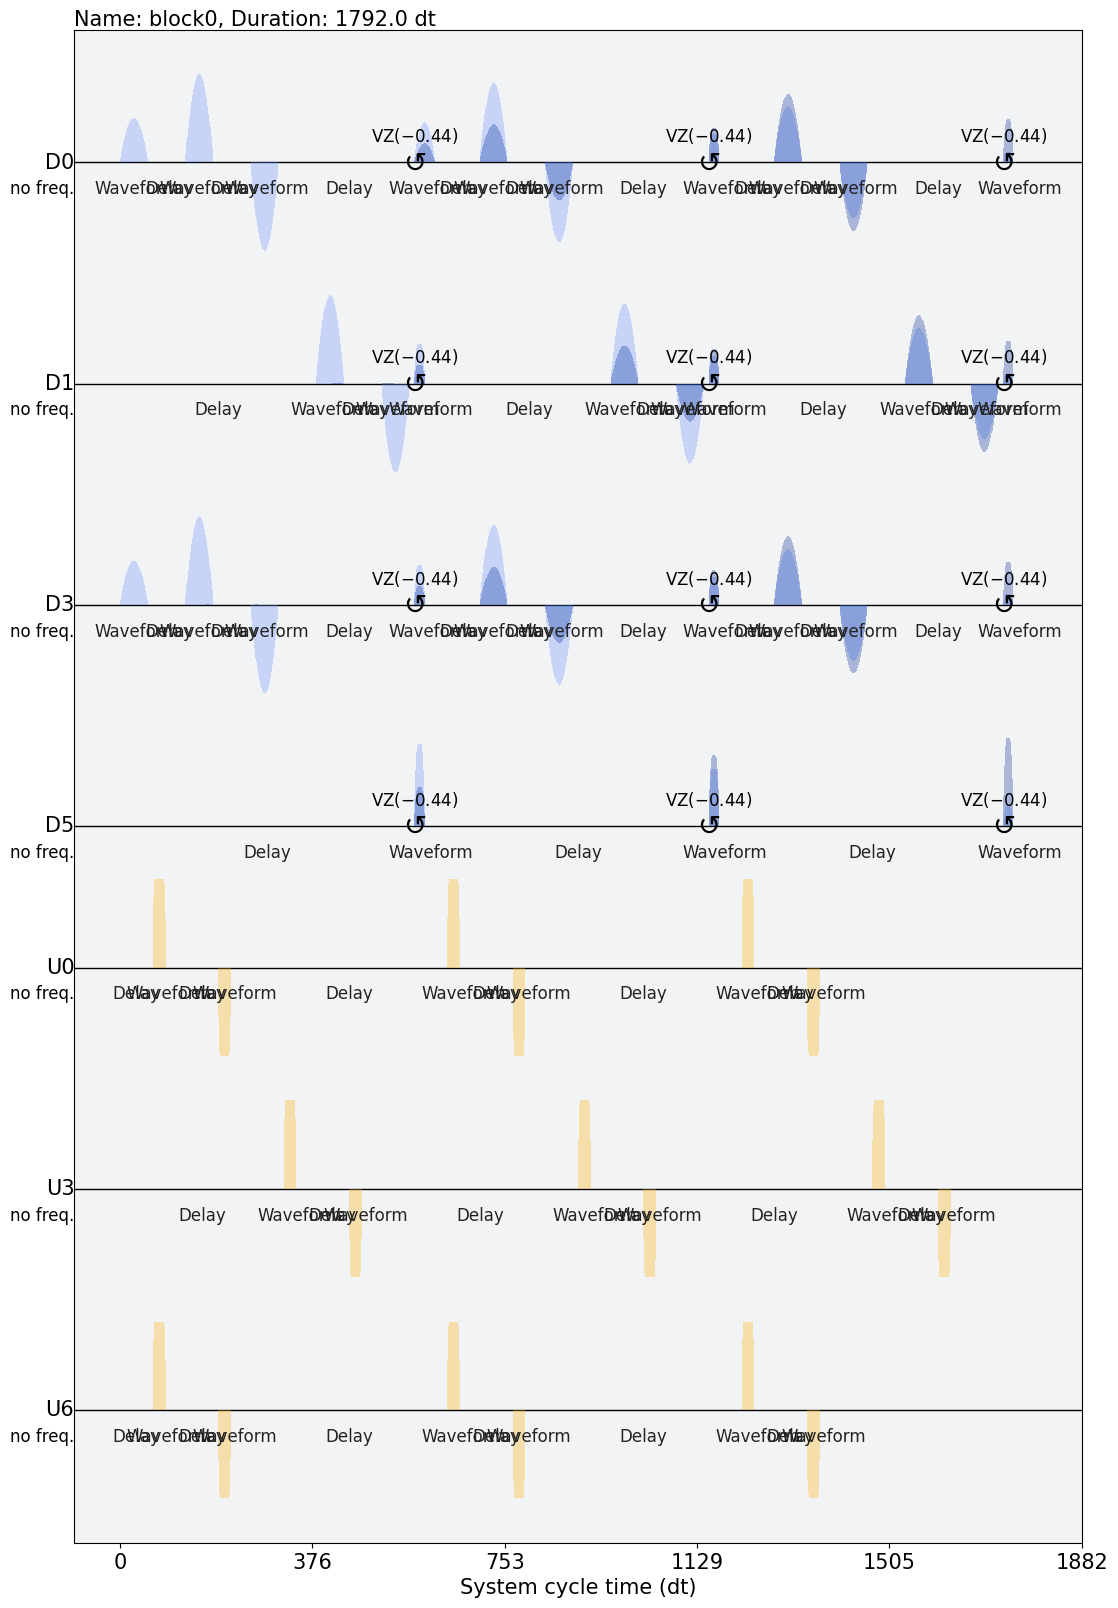

In [18]:
temp_sched.draw()

# Functions to build the problem parameters

In [19]:
def get_qubit_op(dist, mapper="parity"):
    molecule = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver, 
                                            transformers=[ActiveSpaceTransformer(num_electrons=2, 
                                                                                 num_molecular_orbitals=3,
                                                                                active_orbitals=[1,2,5])])
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

### need also a function to get the hamiltonian without the active space approximation

In [20]:
def get_qubit_op_full(dist, mapper="parity"):
    molecule = Molecule(geometry=[["Li", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, dist]]], charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF)
    es_problem = ElectronicStructureProblem(driver)
    second_q_op = es_problem.second_q_ops()
    if mapper == "parity":
        qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    elif mapper == "jordan":
        qubit_converter = QubitConverter(mapper=JordanWignerMapper(), two_qubit_reduction=True)
    elif mapper == "bravi":
        qubit_converter = QubitConverter(mapper=BravyiKitaevMapper(), two_qubit_reduction=True)
    else:
        print("mapper should be one of parity, jordan or bravi")
        return None
    qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
    return qubit_op, es_problem

In [21]:
def get_hf_energy(dist):
    temp_mol = gto.M(atom = 'Li 0 0 0; H 0 0 ' + str(dist), basis = 'sto3g')
    temp_hf = scf.HF(temp_mol)
    return temp_hf.kernel()

In [22]:
def get_accurate_state(dist):
    temp_qubit_op = get_qubit_op(dist)[0]
    eigen_values, eigen_vectors = np.linalg.eigh(temp_qubit_op.to_matrix())
    min_eigen_value = eigen_values[0]
    min_eigen_vector = eigen_vectors.transpose()[0]
    return min_eigen_value, min_eigen_vector

In [23]:
def get_exact_energies(dist):
    numpy_solver = NumPyMinimumEigensolver()
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
    calc = GroundStateEigensolver(qubit_converter, numpy_solver)
    _, es_prob = get_qubit_op(dist)
    temp_res = calc.solve(es_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

In [24]:
def get_paulis_and_coeffs(dist):
    qubit_op = get_qubit_op(dist)[0]
    paulis = []
    for op in qubit_op:
        paulis.append(str(op)[-op.num_qubits:])
    return paulis, qubit_op.coeffs

# Visualization functions

In [25]:
def plot_energies(energies, hf_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, energies, lw=3, label="Exact Energy")
    plt.plot(distances, hf_energies, lw=3, label="HF Energy")
#     plt.fill_between(distances, np.array(energies)-0.0016, np.array(energies)+0.0016, 
#                      alpha=0.2, facecolor='#089FFF', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy')
    plt.legend()
    plt.show()

In [26]:
def plot_energies_error(energies, hf_energies, distances):
    fig = plt.figure(figsize=(8, 5))
    plt.plot(distances, np.abs(np.array(energies) - np.array(hf_energies)), lw=3, label="HF")
    plt.axhline(0.0016, linestyle='--', label="Chemical accuracy")
    plt.xlabel('Atomic distance (Angstrom)')
    plt.ylabel('Energy Error')
    plt.legend()
    plt.show()

In [27]:
def plot_convergence(values_hist_arr, dist):
    values_hist_arr_real = np.array(values_hist_arr[dist])
    paulis, coeffs = get_paulis_and_coeffs(dist)
    values_hist_arr_real = values_hist_arr_real + coeffs[0]
    values_hist_arr_real = np.array([spsa_value.real for spsa_value in values_hist_arr_real])
    
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    min_eigenvalue = min_energy - nuclear_repulsion_energy

    fig = plt.figure(figsize=(8, 5))
    plt.plot(list(range(len(values_hist_arr[dist]))), values_hist_arr_real , lw=3, label="energy")
    plt.plot(list(range(len(values_hist_arr[dist]))), [min_eigenvalue] * len(values_hist_arr_real) , 'k', lw=3, 
             label="optimal energy", linestyle="dashed")
    plt.xlabel("iteration")
    plt.ylabel("Energy")
    plt.legend(frameon=False)
    plt.title("H_2 SPSA convergence")
    plt.show()

In [28]:
def plot_populations_4q_leak(sol_vec, time):
    popu = [psi.probabilities() for psi in sol_vec]
    popu = np.array(popu).transpose()
    leakage = popu[2] + popu[5] + popu[6] + popu[7] + popu[8]

    fig = plt.figure(figsize=(8, 5))
    plt.plot(time, popu[0], lw=3, label="Population in |00>")
    plt.plot(time, popu[1], lw=3, label="Population in |01>")
#     plt.plot(time, popu[2], lw=3, label="Population in |02>")
    plt.plot(time, popu[3], lw=3, label="Population in |10>")
    plt.plot(time, popu[4], lw=3, label="Population in |11>")
    plt.plot(time, leakage, lw=3, label="leakage")
#     plt.plot(time, popu[5], lw=3, label="Population in |12>")
#     plt.plot(time, popu[6], lw=3, label="Population in |20>")
#     plt.plot(time, popu[7], lw=3, label="Population in |21>")
#     plt.plot(time, popu[8], lw=3, label="Population in |22>")
    plt.xlabel("Time (ns)")
    plt.ylabel("Population")
    plt.legend(frameon=False)
    plt.ylim([0, 1.05])
#     plt.xlim([0, sol.t[-1]])
#     plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

# Run the optimization

In [29]:
def evaluate_energy_simulation_multiple_circuits(circuits, paulis, coeffs, system_model, nuclear_repulsion_energy,
                                                 results_dict, dt=0.222, decoherence=False, shots=None):
    cur_step_energies = []
    for circ in circuits:
        ansatz_result = run_ansatz(system_model, circ, dt, decoherence=decoherence)
        expval, stddev = finite_sampling_measure(ansatz_result.y[-1], paulis[1:], coeffs[1:], 
                                                 leakage=True, shots=shots)
        print("energy: " + str(expval + coeffs[0]))
        # in case I will want to return also the varience and the counts
        # return results, expval, stddev

        # save in global variables the mid-optimization values
        energy = expval.real + coeffs[0] + nuclear_repulsion_energy
        results_dict["values"].append(energy)
        cur_step_energies.append(energy)
        print("energy with nuclear repulstion: " + str(energy))
        results_dict["stddev"].append(stddev)
        results_dict["states"].append(ansatz_result.y[-1])
    min_energy = min(cur_step_energies)
    return min_energy, cur_step_energies

def create_optimization_step_circuits(parameters, change_param_index, change_param_range, backend, 
                                      qubits, results_dict, layers=3, dt=0.222):
    circuits = []
    for param_change in change_param_range:
        temp_param_vector = copy.deepcopy(parameters)
        if change_param_index in [0, 1, 2]: # duration and not Rz angle
            param_change = param_change * dt
        temp_param_vector[change_param_index] += param_change
        # build the ansatz
        ansatz = ansatz_gate_inspired_weighted_multiple_layers(temp_param_vector, dt, backend, 
                                                               layers=layers, qubits=qubits)
        # for real device, should call "create_circuits" to add measurement operations and later transpile
        circuits.append(ansatz)
        results_dict["thetas"].append(temp_param_vector)
    return circuits

In [ ]:
dists = [0.3, 0.5, 1, 1.5, 2, 2.5, 3]


results_dict = {}

all_paulis = []
all_coeffs = []
exact_energies = []

backend = backend_lagos
system_model = lagos_model_3levels
qubits = [0,1,3,5]
shots = 10000
dt = 0.222
decoherence = True
layers = 1

number_of_iterations = 1

for dist in dists:
    print("#########################################")
    print("Solving for distance " + str(dist) + ":")
    print("#########################################")
    paulis, coeffs = get_paulis_and_coeffs(dist)
    all_paulis.append(paulis)
    all_coeffs.append(coeffs)
    temp_res, min_energy, nuclear_repulsion_energy = get_exact_energies(dist)
    target_energy = min_energy
    exact_energies.append(target_energy)

    initial_theta = [0, 0, 0, 54 * dt, 108 * dt, -54 * dt, 0, 0, 0, 0, 0] + [0] * 22
    
    parameter_search_space = {
        "0": np.linspace(20, -20, 21),
        "1": np.linspace(30, -30, 21),
        "2": np.linspace(30, -30, 21),
        "3": np.linspace(4, -4, 17),
        "4": np.linspace(4, -4, 17)
    }    
    
    parameters_order = [0, 1, 4, 3, 2]

    cur_dist_res_dict = {"all_runs": {"values": [], "thetas": [], "stddev": [], "states": []},
                         "steps": {"min_energies": [], "min_std": [], "thetas": {}}
                        }
    results_dict[dist] = cur_dist_res_dict

    cur_theta = copy.deepcopy(initial_theta)
    cur_energy = 10
    cur_stddev = 0
    
    tic = time.perf_counter()
    for i in range(number_of_iterations):
        if i >= 2:
            parameter_search_space = {
                "0": np.linspace(5, -5, 11),
                "1": np.linspace(5, -5, 11),
                "2": np.linspace(5, -5, 11),
                "3": np.linspace(0.5, -0.5, 11),
                "4": np.linspace(0.5, -0.5, 11)
            }
        for param_index in parameters_order:
            print("theta: " + str(cur_theta))
            print("working on theta[" + str(param_index) + "]")
            cur_step_circuits = create_optimization_step_circuits(cur_theta, param_index, 
                                                                  parameter_search_space[str(param_index)], 
                                                                  backend, qubits, 
                                                                  cur_dist_res_dict["all_runs"], layers=layers, dt=dt)
            
            step_min_energy, cur_step_energies = evaluate_energy_simulation_multiple_circuits(cur_step_circuits, 
                                                            paulis, coeffs, system_model, 
                                                            nuclear_repulsion_energy, cur_dist_res_dict["all_runs"], 
                                                            dt=dt, decoherence=decoherence, shots=shots)
            print("min energy found: " + str(step_min_energy))
            cur_dist_res_dict["steps"]["min_energies"].append(step_min_energy)
            opt_energy_index = cur_step_energies.index(step_min_energy)
            cur_step_std = cur_dist_res_dict["all_runs"]["stddev"][-len(cur_step_energies):]
            cur_dist_res_dict["steps"]["min_std"] = cur_step_std[opt_energy_index]
            if step_min_energy < cur_energy:
                cur_energy = step_min_energy
                cur_stddev = cur_step_std[opt_energy_index]
                if param_index in [0, 1, 2]:
                    multiplier = dt
                else:
                    multiplier = 1
                cur_theta[param_index] = cur_theta[param_index] + \
                    parameter_search_space[str(param_index)][opt_energy_index] * multiplier
            cur_dist_res_dict["steps"]["theta"] = copy.deepcopy(cur_theta)
            print("updated theta: " + str(cur_theta))
    
    toc = time.perf_counter()

    opt_theta_index = values.index(np.min(values))

    print(f"Finished the VQE in {toc - tic:0.4f} seconds")
    print("final theta: " + str(cur_theta))
    print("min eigen_value found: " + str(cur_energy))
    print("absolute error: " + str(np.abs(cur_energy - target_energy)))
    print("std: " + str(cur_stddev))
    print("number of iterations: " + str(i))
    opt_sched = ansatz_gate_inspired_weighted_multiple_layers(cur_theta, dt, backend, 
                                                               layers=layers, qubits=qubits)
    print("solution schedule duration: " + str(opt_sched.duration * dt) + " [ns]")


## Plot the results

In [ ]:
exp_energies_steepest_hill = []
for dist in dists:
    exp_energies_steepest_hill.append(np.min(results_dict[dist]['steps']['min_energies']).real)

In [ ]:
plot_energies(exact_energies, exp_energies_steepest_hill, dists)

In [ ]:
plot_energies_error(exact_energies, exp_energies, dists)

### The versions of packages used in this notebook

In [31]:
import qiskit.tools.jupyter
%qiskit_version_table

In [32]:
import qiskit_dynamics
qiskit_dynamics.__version__

'0.2.1'